### Convolutional Neural Network (CNN) - Multiclass

**AIM**: Build and train an image classifier to detect images from different animal specie

### Objectives
- Data visualisation
- Data preprocessing and image augmentation
- BUild CNN Model
- Compile and train the model
- Add early stopping callback
- Save and load model
- Model evaluation
- Make prediction on new data

### Prerequisite
- Google colab or Jupyter notebook
- Dogs and Cats datasets
- TensorFlow2

### Check is TensorFlow, NumPy, Pandas and Matplotlib are installed

In [46]:
!pip show tensorflow

Name: tensorflow
Version: 2.19.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, kauldron, tensorflow-text, tensorflow_decision_forests, tf_keras


In [47]:
# !pip show numpy

In [48]:
# !pip show pandas

In [49]:
!pip show matplotlib

Name: matplotlib
Version: 3.10.0
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: Unknown <matplotlib-users@python.org>
License: License agreement for matplotlib versions 1.3.0 and later

 1. This LICENSE AGREEMENT is between the Matplotlib Development Team
 ("MDT"), and the Individual or Organization ("Licensee") accessing and
 otherwise using matplotlib software in source or binary form and its
 associated documentation.

 2. Subject to the terms and conditions of this License Agreement, MDT
 hereby grants Licensee a nonexclusive, royalty-free, world-wide license
 to reproduce, analyze, test, perform and/or display publicly, prepare
 derivative works, distribute, and otherwise use matplotlib
 alone or in any derivative version, provided, however, that MDT's
 License Agreement and MDT's notice of copyright, i.e., "Copyright (c)
 2012- Matplotlib Development Team; All Rights Reserved" are retained in
 matplotlib

In [50]:
import os
import sys
import random
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

In [51]:
# Set seed for reproducibility

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [52]:
# Check for GPU
!nvidia-smi

Sat Dec 27 15:00:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   78C    P0             37W /   70W |   12069MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [53]:
# Check if TensorFlow can detect any GPU
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    print(f"GPUs available: {len(gpus)}")

    for gpu in gpus:
        print(f"- {gpu}")
else:
    print("No GPUs found.")

GPUs available: 2
- PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
- PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


In [54]:
gpus = tf.config.list_physical_devices("GPU")
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [55]:
# Get the total number of GPUs and names
if gpus:
    print(f"Total number of GPUs: {len(gpus)}")
    
    for gpu in gpus:
        print(f"GPU Name: {gpu}")
else:
    print("No GPU available")

Total number of GPUs: 2
GPU Name: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU Name: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


In [56]:
# Check TensorFlow version
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.19.0


In [57]:
# CReate a director called "models" to store model files during training

if not os.path.isdir("models"):
    os.mkdir("models")

In [58]:
# Set path to the main dataset directory
base_path = "/kaggle/input/animal-image-classification-dataset"
base_path = pathlib.Path(base_path) # A modern way to handle filepaths

base_path

PosixPath('/kaggle/input/animal-image-classification-dataset')

In [59]:
# Set path to the training dataset
train_path = base_path / "Training Data" / "Training Data"
train_path

PosixPath('/kaggle/input/animal-image-classification-dataset/Training Data/Training Data')

In [60]:
# Set the path to the validation and test datasets
validation_path = base_path / "Validation Data"/ "Validation Data"

In [61]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
BATCH_SIZE = 256
EPOCHS = 300

In [62]:
# Load dataset
# Using `image_dataset_from_directory (recommended and stable)
# Instead of using the 'ImageDataGenerator()' class

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    # validation_split=0.1,
    # subset="training",
    seed=SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
)

Found 30000 files belonging to 15 classes.


In [63]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_path,
    seed=SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
)

Found 2000 files belonging to 15 classes.


In [64]:
# Get the class names
class_names = train_dataset.class_names
number_classes = len(class_names)

print(f"Number of classes: {number_classes}")
print(f"Class names: {list(class_names)}")

Number of classes: 15
Class names: ['Beetle', 'Butterfly', 'Cat', 'Cow', 'Dog', 'Elephant', 'Gorilla', 'Hippo', 'Lizard', 'Monkey', 'Mouse', 'Panda', 'Spider', 'Tiger', 'Zebra']


### Sanity Check: Visualise dataset samples 
- Confirms correct labels
- Detects corrupt images
- Verifies colour channels, orientation, resolution

In [65]:
# Verify (test)

train_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [66]:
# Capture exactly ONE batch and store it in memory
# This "freezes" the random augmentations for this specific set
for images, labels in train_dataset.take(1):
    fixed_images = images.numpy()
    fixed_labels = labels.numpy()

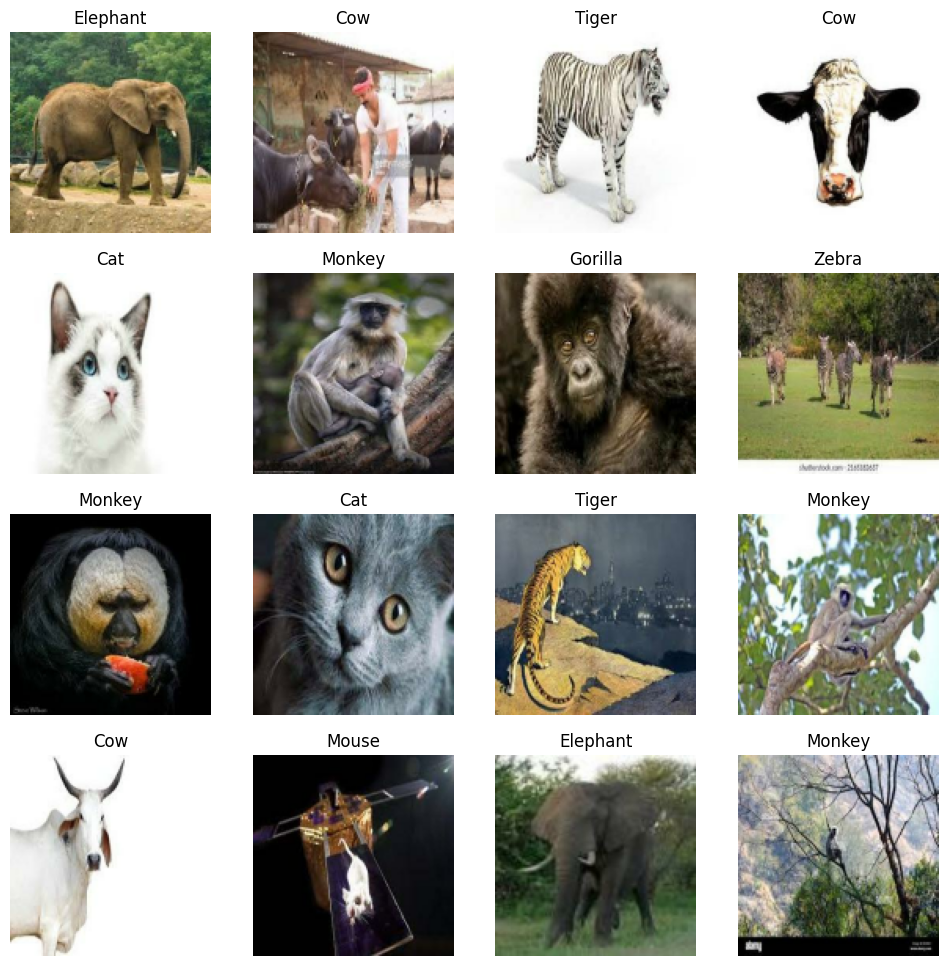

In [67]:
# Visualisation
# No matter how many times you run this cell, the images won't change.
plt.figure(figsize=(12, 12))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(fixed_images[i].astype("uint8"))
    plt.title(class_names[fixed_labels[i]])
    plt.axis("off")

### Performance Optimisation

Using `tf.data.AUTOTUNE` and the specific method below creates an asynchronous pipeline—basically, it allows the CPU to prepare the next batch while the GPU is still processing the current one.

In [ ]:
# AUTOTUNE allows TensorFlow to dynamically adjust the resource allocation 
# (like CPU threads) based on your hardware's current workload at runtime.
# Read more at https://www.tensorflow.org/tutorials/load_data/images

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = (
    train_dataset
    # Keep the data in memory (RAM) after the first epoch.
    # This prevents the CPU from having to re-read and re-decode JPEGs 
    # from the slow hard drive during every subsequent training round.
    .cache()

    # Maintain a buffer of 1,000 samples and randomly pulls from it.
    # This ensures the model doesn't learn the order of the files, 
    # but rather the features of the images.
    .shuffle(1000)

    # Overlaps the data preprocessing and model execution.
    # While the GPU is training on the current batch, the CPU is already 
    # preparing the next batch in the background. This eliminates "GPU starvation."
    .prefetch(buffer_size=AUTOTUNE)
)

In [69]:
validation_dataset = (
    validation_dataset
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

### Data Augmentation (Modern Keras Layers)

In [70]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

###  A more modern CNN architecture (Vanilla CNN)

In [71]:
def build_cnn_model(input_shape, num_classes):

    inputs = tf.keras.Input(shape=input_shape)

    x = data_augmentation(inputs)
    x = tf.keras.layers.Rescaling(1.0/255)(x)

    # ConvNet Block 1
    x = tf.keras.layers.Conv2D(32, 3, padding="same", use_bias="False")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    # ConvNet Block 2
    x = tf.keras.layers.Conv2D(64, 3, padding="same", use_bias="False")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    # ConvNet Block 3
    x = tf.keras.layers.Conv2D(128, 3, padding="same", use_bias="False")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    # ConvNet Block 4
    x = tf.keras.layers.Conv2D(256, 3, padding="same", use_bias="False")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    # ConvNet Block 5
    x = tf.keras.layers.Conv2D(512, 3, padding="same", use_bias="False")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    
    # Classifier
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.1)(x)

    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.1)(x)

    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.1)(x)



    # Outputs
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    # Build model
    model = tf.keras.Model(inputs, outputs)

    return model

### Build and Compile the Model

In [72]:
# Build the model

model = build_cnn_model(
    input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH) + (3,),
    num_classes=number_classes
)

In [73]:
# Verify model architecture
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,008,655 (7.66 MB)

 Trainable params: 2,006,671 (7.65 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [74]:
# Compile the model

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

### Configure Callbacks

In [75]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="models/best_animal_cnn.keras",
    monitor="val_accuracy",
    save_best_only=True,
    # verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=5,
    verbose=1
)


callbacks = [model_checkpoint, early_stopping, reduce_learning_rate]

### Train the model to learn patterns from the images

In [76]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 73s 430ms/step - accuracy: 0.1934 - loss: 2.4553 - val_accuracy: 0.0985 - val_loss: 3.4225 - learning_rate: 0.0010
Epoch 2/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 47s 402ms/step - accuracy: 0.3485 - loss: 2.0180 - val_accuracy: 0.0960 - val_loss: 3.5453 - learning_rate: 0.0010
Epoch 3/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 48s 411ms/step - accuracy: 0.4148 - loss: 1.8358 - val_accuracy: 0.1645 - val_loss: 3.3919 - learning_rate: 0.0010
Epoch 4/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 48s 410ms/step - accuracy: 0.4657 - loss: 1.6766 - val_accuracy: 0.3150 - val_loss: 2.1569 - learning_rate: 0.0010
Epoch 5/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 48s 410ms/step - accuracy: 0.5052 - loss: 1.5623 - val_accuracy: 0.3990 - val_loss: 2.0101 - learning_rate: 0.0010
Epoch 6/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 48s 410ms/step - accuracy: 0.5334 - loss: 1.4767 - val_accuracy: 0.4535 - val_loss: 1.7770 - learning_rate: 0.0010
Epoch 7/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 48s 408ms/step - accura

### Plot Training Curves (Learning Dynamics)

In [77]:
def plot_learning_curves(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(len(acc))


    plt.figure(figsize=(18, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Training Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend()
    plt.title("Loss")

    plt.show()


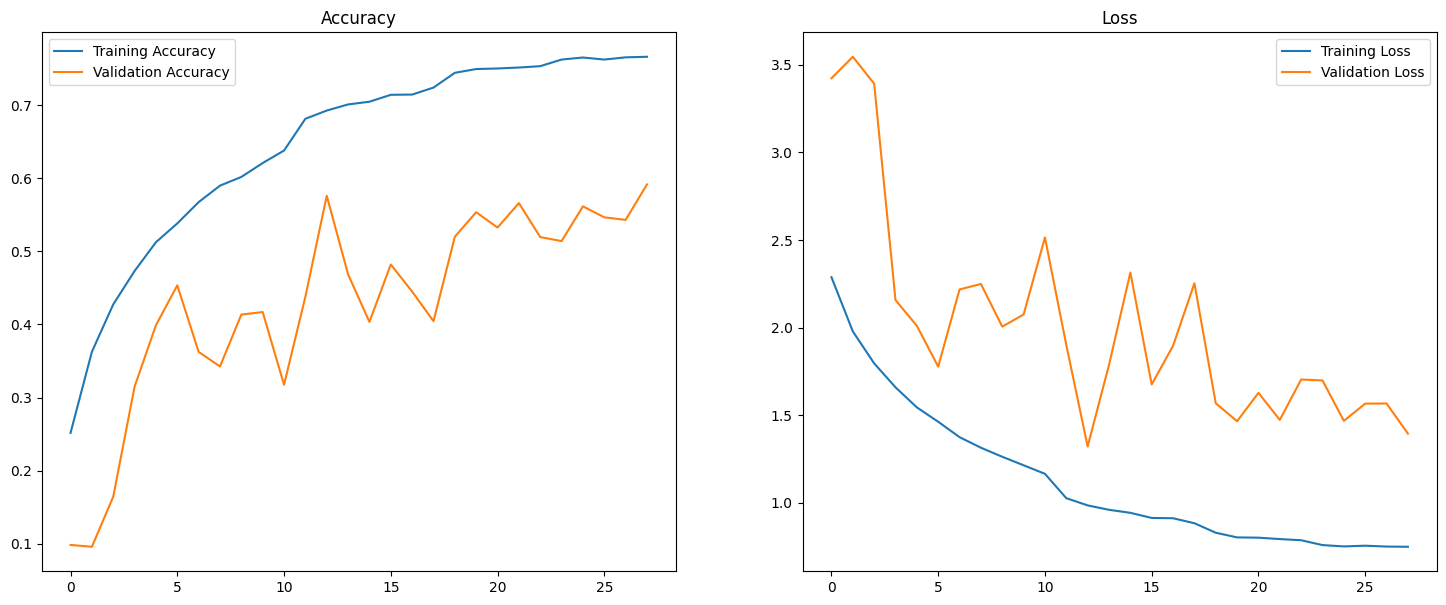

In [78]:
plot_learning_curves(history)

### Generate Predictions (TensorFlow to NumPy)

In [79]:
loss, accuracy = model.evaluate(validation_dataset)

print(f"Model Loss: {loss:.2f}")
print(f"Model Accuracy: {accuracy:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.5754 - loss: 1.3562
Model Loss: 1.32
Model Accuracy: 0.58


In [80]:
y_true = []
y_pred = []
y_prob = []

for images, labels in validation_dataset:
    preds = model.predict(images, verbose=1) # Try verbose=0
    y_prob.append(preds)
    y_pred.append(np.argmax(preds, axis=1))
    y_true.append(labels.numpy())

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


In [81]:
len(y_true), len(y_pred), len(y_prob)

(8, 8, 8)

In [82]:
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
y_prob = np.concatenate(y_prob)

### Core Classification Metrics (from scikit-learn)

In [83]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)



print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.2f}")
print(f"Recall (macro): {recall_score(y_true, y_pred, average="macro"):.2f}")
print(f"F1-score (macro): {f1_score(y_true, y_pred, average="macro"):.2f}")

Accuracy: 0.58
Precision (macro): 0.60
Recall (macro): 0.57
F1-score (macro): 0.57


In [84]:
# Full Classification Report

print(classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
))


              precision    recall  f1-score   support

      Beetle     0.7551    0.5550    0.6398       200
   Butterfly     0.5675    0.7150    0.6327       200
         Cat     0.5067    0.3800    0.4343       100
         Cow     0.4742    0.4600    0.4670       100
         Dog     0.5690    0.3300    0.4177       100
    Elephant     0.8939    0.5900    0.7108       100
     Gorilla     0.6283    0.7100    0.6667       100
       Hippo     0.3721    0.8000    0.5079       100
      Lizard     0.4764    0.7050    0.5685       200
      Monkey     0.2887    0.2800    0.2843       100
       Mouse     0.6480    0.4050    0.4985       200
       Panda     0.9457    0.8700    0.9062       100
      Spider     0.6687    0.5550    0.6066       200
       Tiger     0.6071    0.5100    0.5543       100
       Zebra     0.6154    0.7200    0.6636       100

    accuracy                         0.5760      2000
   macro avg     0.6011    0.5723    0.5706      2000
weighted avg     0.6066   

In [85]:
# cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

# plt.figure(figsize=(14, 12))
# sns.heatmap(cm_norm, cmap="Blues", cbar=False, annot=True,
#             xticklabels=class_names, yticklabels=class_names)
# plt.title("Confusion Matrix (Normalized)")
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.xticks(rotation=45, ha="right")
# plt.show()

In [86]:
# ROC–AUC (One-vs-Rest, Multi-Class)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

y_true_bin = label_binarize(y_true, 
                            classes=range(number_classes))

roc_auc_macro = roc_auc_score(
    y_true_bin,
    y_prob,
    average="macro",
    multi_class="ovr"
)

roc_auc_weighted = roc_auc_score(
    y_true_bin,
    y_prob,
    average="weighted",
    multi_class="ovr"
)

print("ROC-AUC (macro):", roc_auc_macro)
print("ROC-AUC (weighted):", roc_auc_weighted)


ROC-AUC (macro): 0.92838977582846
ROC-AUC (weighted): 0.9265591374269007


In [87]:
# Precision–Recall AUC (PR-AUC)

from sklearn.metrics import average_precision_score

pr_auc_macro = average_precision_score(
    y_true_bin,
    y_prob,
    average="macro"
)

pr_auc_weighted = average_precision_score(
    y_true_bin,
    y_prob,
    average="weighted"
)

print("PR-AUC (macro):", pr_auc_macro)
print("PR-AUC (weighted):", pr_auc_weighted)

PR-AUC (macro): 0.6436369802369419
PR-AUC (weighted): 0.6521570265823212


In [88]:
# Top-K Accuracy (Important for 90 Classes)

top_5_acc = tf.keras.metrics.top_k_categorical_accuracy(
    y_true_bin,
    y_prob,
    k=5
).numpy().mean()

print("Top-5 Accuracy:", top_5_acc)


Top-5 Accuracy: 0.905


In [89]:
# TensorFlow Native Metrics

tf_acc = tf.keras.metrics.SparseCategoricalAccuracy()
tf_acc.update_state(y_true, y_prob)
print("TF Accuracy:", tf_acc.result().numpy())

TF Accuracy: 0.576


In [90]:
# Saving the Model

model.save("animals_224x224_final.keras")

**This resulted in a poor model. We will use transfer learning to see how to improve the model using any of the model which is already doing well in general image processing tasks.**